   instant    dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011/1/1       1   0     1   0        0        6           0   
1        2  2011/1/1       1   0     1   1        0        6           0   
2        3  2011/1/1       1   0     1   2        0        6           0   
3        4  2011/1/1       1   0     1   3        0        6           0   
4        5  2011/1/1       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


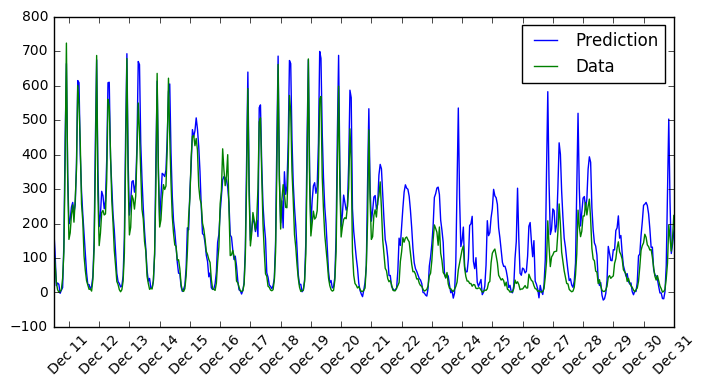

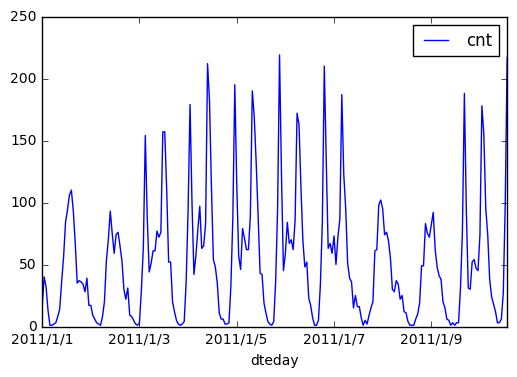

Progress: 99.9% ... Training loss: 0.057 ... Validation loss: 0.197

.....

Progress: 99.9% ... Training loss: 0.056 ... Validation loss: 0.207


----------------------------------------------------------------------
Ran 5 tests in 0.009s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

print(rides.head())

rides[:24*10].plot(x='dteday', y='cnt')
plt.show()

#variables like season, weather, month, make binary dummy variables
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)

#standardize each of the continuous variables
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
data.head()

test_data = data[-21*24:]

data = data[:-21*24]

target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]


#build the network
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        #activation_function
        self.activation_function = (lambda x: 1/(1 + np.exp(-x)))
        
    def dolgit(self,x):
        return x*(1-x)
    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        ### Forward pass ###
        # TODO: Hidden layer - Replace these values with your calculations.
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) # signals into hidden layer
        hidden_outputs =  self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with your calculations.
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer
        
        #### Implement the backward pass here ####
        ### Backward pass ###
        
        # TODO: Output error - Replace this value with your calculations.
        output_errors = targets - final_outputs # Output layer error is the difference between desired target and actual output.
        
        # TODO: Backpropagated error - Replace these values with your calculations.
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors)  # errors propagated to the hidden layer
        hidden_grad = hidden_outputs*(1.0 - hidden_outputs) # hidden layer gradients
        
        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += output_errors * hidden_outputs.T * self.lr  # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * np.dot(hidden_errors * hidden_grad, inputs.T) # update input-to-hidden weights with gradient descent step
 
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)  # signals into hidden layer
        hidden_outputs =  self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs
    
def MSE(y, Y):
    return np.mean((y-Y)**2)
        

import sys
### Set the hyperparameters here ###
epochs = 6400
learning_rate = 0.01
hidden_nodes = 30
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)
    
    
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

#unittests
import unittest

inputs = [0.5, -0.2, 0.1]
targets = [0.4]
test_w_i_h = np.array([[0.1, 0.4, -0.3], 
                       [-0.2, 0.5, 0.2]])
test_w_h_o = np.array([[0.3, -0.1]])

class TestMethods(unittest.TestCase):
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328, -0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014,  0.39775194, -0.29887597],
                                              [-0.20185996,  0.50074398,  0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromTestCase(TestMethods)
unittest.TextTestRunner().run(suite)